TMDB Multimodal Genre Classification

The goal of this project is to classify movie genres by leveraging both poster images and textual overviews available from The Movie Database (TMDB). Our visual features are extracted from movie posters using EfficientNetB0, and our text features are extracted form plot overviews using LSTM layers on embedded sequences. 

This project demonstrates a hybrid deep learning model that combines visual and textual features for genre classification. It uses EfficientNet for image feature extraction and a dense network for text embeddings.

Github - https://github.com/Alexi013/TMDB-Multimodal-Genre-Classification/tree/main

In [68]:
import os, re, time, requests
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [3]:
NUM_MOVIES = 400
IMG_SIZE = 224
MAX_LEN = 150
NUM_WORDS = 10000

In [4]:
TMDB_BEARER_TOKEN = 'your_token_here'
BASE_URL = "https://api.themoviedb.org/3"
IMG_BASE_URL = "https://image.tmdb.org/t/p/w500"

Note: This notebook originally used a TMDB API token for data retrieval. For security, the token has been removed ('TOKEN_REMOVED').
To run this notebook, you must supply your own valid TMDB_BEARER_TOKEN.

In [6]:
def clean_filename(name):
    return re.sub(r'[\\/*?\":<>|]', "", name.replace(" ", "_"))

def download_poster(title, poster_path, save_dir="posters"):
    os.makedirs(save_dir, exist_ok=True)
    url = f"{IMG_BASE_URL}{poster_path}"
    safe_title = clean_filename(title)
    save_path = os.path.join(save_dir, f"{safe_title}.jpg")
    if not os.path.exists(save_path):
        try:
            img_data = requests.get(url).content
            with open(save_path, 'wb') as handler:
                handler.write(img_data)
        except:
            return None
    return save_path

def fetch_movies(pages=5):
    headers = {
        "Authorization": f"Bearer {TMDB_BEARER_TOKEN}",
        "accept": "application/json"
    }
    all_movies = []
    for page in tqdm(range(1, pages + 1)):
        url = f"https://api.themoviedb.org/3/movie/popular?page={page}"
        try:
            res = requests.get(url, headers=headers)
            res.raise_for_status()
            data = res.json()["results"]
            for movie in data:
                if not movie.get("poster_path") or not movie.get("overview"):
                    continue
                poster_path = download_poster(movie["title"], movie["poster_path"])
                movie["poster_file"] = poster_path
                if movie["poster_file"]:
                    all_movies.append(movie)
        except Exception as e:
            print(f"Failed to fetch page {page}: {e}")
        time.sleep(0.1)
    return pd.DataFrame(all_movies)

In order to create a multimodal model, we have to collect movie metadata - for us this is the title, genre, overview,and poster. 50 pages were selected as there are about 20 movies per page so we will be left with a dataset of ~1000 movies!

Once again, the TMDB API was used to fetch this data. The data is specifically pulled from the movie/popular section.

The code above cleans the title for safe naming, downloads images locally, and a loop function to store metadata and poster images in a dataframe.

In [8]:
print("\nFetching movie metadata and posters...")
df = fetch_movies(pages=50)
df = df.dropna(subset=['poster_file', 'overview'])
print(f"Collected {len(df)} movies")


Fetching movie metadata and posters...


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]

Collected 995 movies


After defining the data collection functions, we call fetch_movies(pages=50) to retrieve metadata and posters for 50 pages (~1,000 movies). We then drop any entries with missing poster images or overviews to ensure our dataset is clean and usable.

The resulting DataFrame contains only movies with both an overview and a poster image.

In [10]:
print(df.columns.tolist())

['adult', 'backdrop_path', 'genre_ids', 'id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'release_date', 'title', 'video', 'vote_average', 'vote_count', 'poster_file']


This line helps us understand the structure of the data and determine which fields we’ll use for modeling.

In [12]:
genre_map = {
    28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy',
    80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family',
    14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music',
    9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction',
    10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'
}

Genre mapping came directly from TMDB API documentation. The TMDB API provides movie genres as numerical genre_ids. This dictionary maps those numerical IDs to readable genre names. This mapping will be used later to interpret and visualize genres more clearly in our analysis and model output.

In [44]:
def map_genre_ids(genre_id_list):
    return [genre_map.get(gid, 'Unknown') for gid in genre_id_list]

df = df[df['genres'].apply(lambda x: len(x) > 0)].copy()

df['primary_genre'] = df['genres'].apply(lambda x: x[0])

df[['title', 'primary_genre', 'overview']].head()

,title,primary_genre,overview
0,Final Destination Bloodlines,Horror,"Plagued by a violent recurring nightmare, coll..."
1,Lilo & Stitch,Family,The wildly funny and touching story of a lonel...
2,Crazy Lizard,Action,A young man climbs into the mountains to pick ...
3,The Twisters,Action,A deadly patchwork of destructive cyclones is ...
4,Distant,Science Fiction,"After crash-landing on an alien planet, an ast..."


This shows us the first 5 rows of our dataset, confirming that our data was successfully extracted and aligned in order for us to build our model. Our dataset is clean and ready for building our multimodal model. 

In [47]:
print(df['primary_genre'].value_counts())

primary_genre
Action             226
Drama              127
Animation          106
Horror             101
Comedy              83
Adventure           77
Romance             55
Science Fiction     47
Family              37
Thriller            32
Fantasy             29
Crime               26
Documentary         14
Mystery             12
War                  8
Western              5
Music                3
History              2
Name: count, dtype: int64


We can see that our most common genres are Action (226 entries), Drama (127 entries), and Animation (105 entries). We also have 3 Unknown entries which we will remove later.

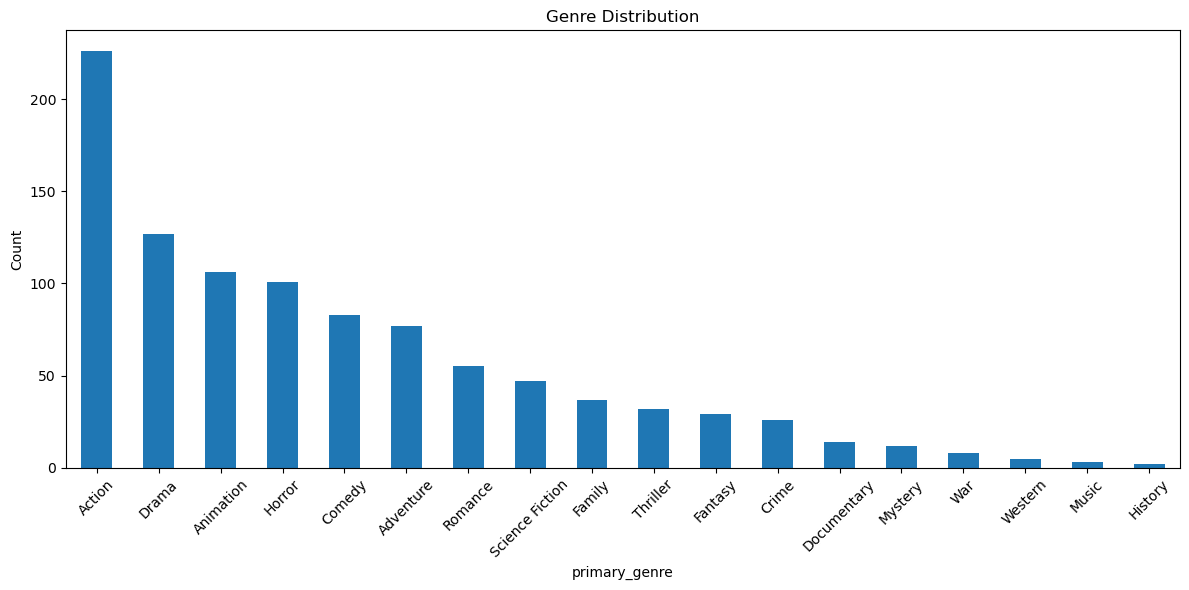

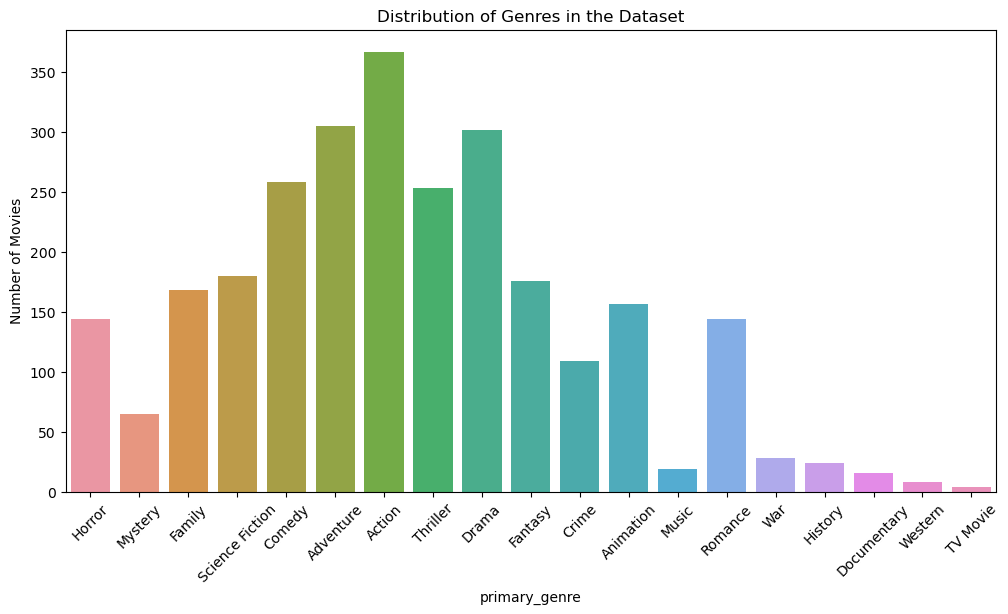

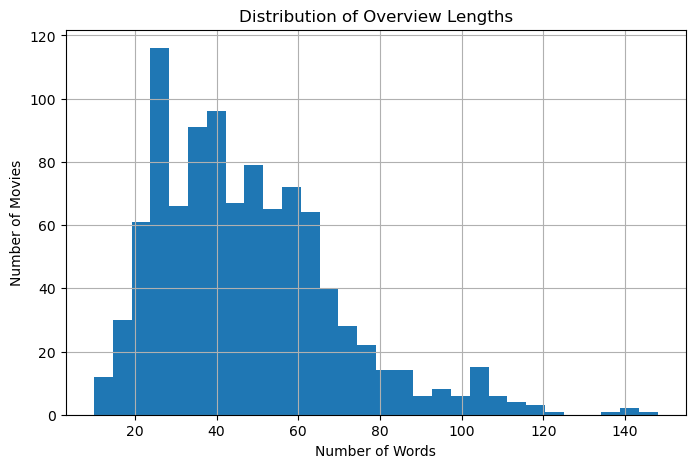

In [54]:
df['primary_genre'].value_counts().plot(kind='bar', figsize=(12, 6), title='Genre Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

genre_counts = Counter(g for genres in df['genre_ids'] for g in genres)
genre_names = [genre_map[k] for k in genre_counts.keys()]
counts = list(genre_counts.values())

plt.figure(figsize=(12,6))
sns.barplot(x=genre_names, y=counts)
plt.title('Distribution of Genres in the Dataset')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('primary_genre')
plt.show()

df['overview_length'] = df['overview'].apply(lambda x: len(str(x).split()))
df['overview_length'].hist(bins=30, figsize=(8,5))
plt.title("Distribution of Overview Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Movies")
plt.show()

In order to better understand the data, 3 visualizations were created. The first plot shows the "primary genre" of the film and it reinforces the dominance Action, Drama, and Animation have in the dataset. We also note that genres such as Music, History, and Western were underrepresented. Also want to note Unkown will be removed from the dataset. 

Our second plot shows every genre that is associated with a movie, and we continue to see Action dominate the dataset but we now see Action have more entries along with Drama remaining heavy in the data.

Our final plot shows the length of the movie's plot overview. We note that a majority of plot length falls between 20-70 words with the max being a little over 140. This will help us determine our MAX_LEN for tokenization.

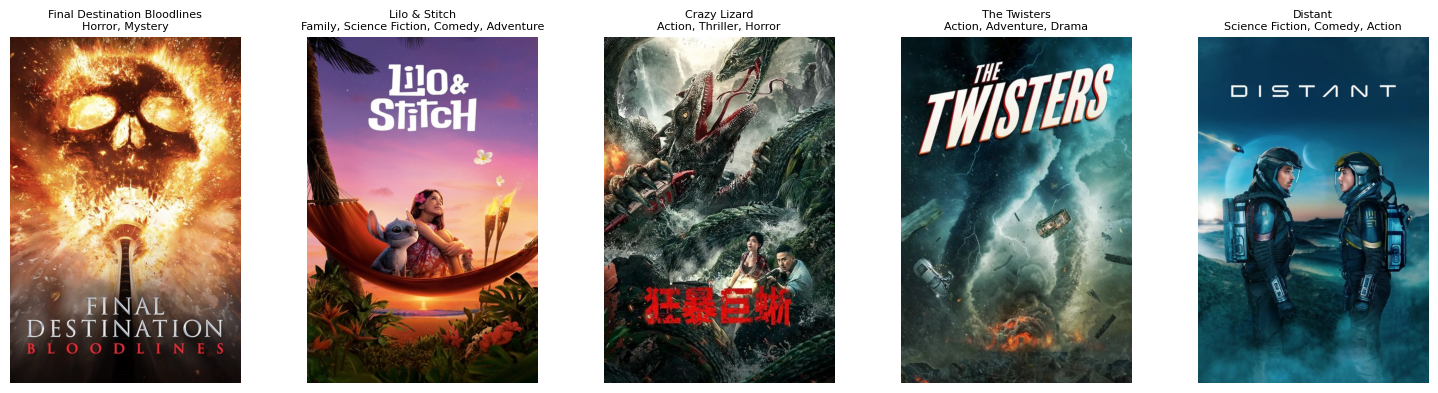

In [57]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for ax, (_, row) in zip(axes, df.iterrows()):
    img = Image.open(row['poster_file'])
    ax.imshow(img)
    ax.axis('off')
    
    genre_names = [genre_map.get(genre_id, '') for genre_id in row['genre_ids']]
    title = row['title']
    ax.set_title(f"{title}\n{', '.join(genre_names)}", fontsize=8)

plt.tight_layout()
plt.show()

Above is a sample set showcasing five movie posters along with their corresponding genres, all pulled directly from our dataset. These previews give us insight into the visual diversity of posters and how certain genres might carry distinctive visual patterns.

For example, Horror posters may often feature darker tones, while Comedy or Animation might lean toward brighter, more vibrant colors. These genre-based visual cues are critical for our image encoder (EfficientNet) to learn and contribute to accurate classification in our multimodal model.

In [60]:
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['overview'])
sequences = tokenizer.texts_to_sequences(df['overview'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

To prepare the movie overviews for input into our neural network, we first tokenize the text using TensorFlow's Tokenizer. We set a vocabulary limit of NUM_WORDS = 10,000 and assign a special token <OOV> for out-of-vocabulary words.

We then convert the plot overviews into sequences of integers (texts_to_sequences) and then pad all sequences to a uniform length of MAX_LEN = 150 words using pad_sequences. What this does it that it ensures all input sentences are consistent.

In [63]:
def load_and_preprocess_image(path):
    img = Image.open(path).resize((IMG_SIZE, IMG_SIZE)).convert('RGB')
    return preprocess_input(np.array(img))

image_data = np.array([load_and_preprocess_image(p) for p in df['poster_file']])

The movie posters also have to be preprocessed in order to make them suitable for input into a convolutional neural network (CNN). Each poster is resized to 224x224 pixels to match the EfficientNet requirements, converted to RGB format to once again enforce consistency. This all resuts in an array suitable for training with our visual encoder.

In [72]:
df = df[df['genre_ids'].apply(lambda ids: all(g in genre_map for g in ids))].reset_index(drop=True)

le = LabelEncoder()
df['genre_encoded'] = le.fit_transform(df['primary_genre'])

labels = to_categorical(df['genre_encoded'])

Before training, any movie entries with unrecognized or invalid genre IDs aare dropped. This is done by ensuring all genre IDs in a movie’s genre_ids list are present in our genre_map. This step helps avoid unknown labels that could disrupt training.

Then the primary_genre column is prepared for classification by converting it into a one-hot encoded format using to_categorical, allowing it to be used as the target variable in a neural network (for single-label classification).

In [75]:
image_data = np.array([load_and_preprocess_image(p) for p in df['poster_file']])
mlb = MultiLabelBinarizer()
y_multi = mlb.fit_transform(df['genre_ids'])

X_text = padded_sequences[:len(df)]
X_img = image_data[:len(df)]

X_text_train, X_text_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    X_text, X_img, y_multi, test_size=0.2, random_state=42
)

To train the multimodal model, both image and text inputs are needed along with multi-label genre targets.

MultiLabelBinarizer is used to convert the list of genre IDs into a binary matrix for multi-label classification.

X_text and X_img align the processed text and image arrays with the cleaned dataset.

The data is then split into training and validation sets using an 80/20 split with train_test_split.

All of this ensures that both our input modalities (text and images) and their corresponding multi-label genre outputs are properly formatted and ready for model training.

In [78]:
text_input = Input(shape=(150,))
embed = Embedding(10000, 128)(text_input)
lstm = LSTM(64)(embed)

image_input = Input(shape=(224, 224, 3))
cnn_base = EfficientNetB0(include_top=False, input_tensor=image_input, weights='imagenet')
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn_out = Dropout(0.3)(cnn_out)

concat = Concatenate()([lstm, cnn_out])
dense = Dense(64, activation='relu')(concat)
output = Dense(y_train.shape[1], activation='sigmoid')(dense)

model = Model(inputs=[text_input, image_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

A hybrid neural network was designed with two input branches:
- visual features are extracted from movie posters using EfficientNetB0
- text features are extracted form plot overviews using LSTM layers on embedded sequences.

The outputs of both branches are concatenated and passed through a dense layer with a sigmoid activation. We use binary_crossentropy as the loss function due to the multi-label setup.

In [81]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]

model.fit(
    [X_text_train, X_img_train], y_train,
    validation_data=([X_text_val, X_img_val], y_val),
    epochs=10, batch_size=32, callbacks=callbacks
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.0371 - loss: 0.5480 - val_accuracy: 0.2778 - val_loss: 0.3671 - learning_rate: 0.0010
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 942ms/step - accuracy: 0.3878 - loss: 0.2701 - val_accuracy: 0.2172 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 944ms/step - accuracy: 0.3610 - loss: 0.1921 - val_accuracy: 0.2071 - val_loss: 0.3637 - learning_rate: 0.0010
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 952ms/step - accuracy: 0.4241 - loss: 0.1367 - val_accuracy: 0.2778 - val_loss: 0.3328 - learning_rate: 0.0010
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 944ms/step - accuracy: 0.4821 - loss: 0.0962 - val_accuracy: 0.2475 - val_loss: 0.3728 - learning_rate: 3.0000e-04
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 938ms/step - accuracy: 0.4735 - loss: 0.0787 - val_accuracy: 0.2677 - val_loss: 0.3619 - learning_rate: 3.0000e-04
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 950ms/step - accuracy: 0.4631 - los

To try and help prevent overfitting, early stopping was used with patience of 5 epochs. A learning rate scheduler (ReduceLROnPlateau) helps the optimizer adjust when validation loss plateaus.

The model was trained over 10 epochs with a batch size of 32 using both the poster image and the overview text as input.

In [86]:
preds = model.predict([X_text_val, X_img_val])
pred_labels = (preds > 0.3).astype(int) 
true_labels = y_val
label_names = mlb.classes_ 

for i in range(5):
    pred_genres = [genre_map.get(label_names[j], str(label_names[j])) for j in range(len(pred_labels[i])) if pred_labels[i][j] == 1]
    true_genres = [genre_map.get(label_names[j], str(label_names[j])) for j in range(len(true_labels[i])) if true_labels[i][j] == 1]
    print(f"Predicted: {pred_genres}")
    print(f"Actual:    {true_genres}")
    print("---")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 495ms/step
Predicted: ['Animation', 'Comedy', 'Family']
Actual:    ['Adventure', 'Animation', 'Comedy', 'Family']
---
Predicted: ['Drama', 'Horror', 'Action', 'Thriller', 'Crime']
Actual:    ['Horror', 'Action', 'Thriller']
---
Predicted: ['Adventure', 'Animation', 'Comedy', 'Family']
Actual:    ['Adventure', 'Animation', 'Action', 'Comedy', 'Family']
---
Predicted: ['Action', 'Thriller']
Actual:    ['Adventure', 'Fantasy', 'Action']
---
Predicted: ['Adventure', 'Animation', 'Comedy', 'Family']
Actual:    ['Animation', 'Comedy', 'Science Fiction', 'Family']
---


After training, predictions are generated on the validation set. A threshold of 0.3 is used to determine which genres are predicted.

With the output, we can see that the model trained for 7 epochs after stopping early due to the Val Accuracy not getting better after 5 epochs. 

Further inspecting the outputs, there is the possibility of overfitting and limited generalizability. While we see steady improvements for training accuracy (~17% to nearly 49%), our validation accuracy plateaued in the low 20–28% range and never showed consistent improvement. This plateauing could suggest overfitting as the model might be learning patterns specific to the training data that do not transfer well to unseen data.

Our validation loss also remained relatively stagnant despite training loss decreasing. This further reinforces that the model is memorizing rather than generalizing, which limits its ability to perform well on new examples.

In respect to the limited generalizability, certain genres like "Action" or "Comedy" are overrepresented in predictions, indicating the model is biased toward dominant classes in the dataset. Class imbalance might be heavily prevalent in the dataset and might require for higher representation.

In [93]:
loss, acc = model.evaluate([X_text_val, X_img_val], y_val)
print(f"\nValidation Accuracy: {acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.2406 - loss: 0.3078

Validation Accuracy: 0.22


This confirms that the final validation accuracy is approximately 22%, which aligns with earlier observations of limited generalization. Despite the model capturing training patterns, its predictive strength on unseen data remains constrained — reinforcing the impact of class imbalance and potential overfitting.

In [96]:
preds = model.predict([X_text_val, X_img_val])
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y_val, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


To further assess model performance, predictions are made on the validation set. Since the model uses a sigmoid activation function for multi-label classification, np.argmax() is used to retrieve the highest-probability class for each example. This helps us get a single predicted label to compare against the true primary genre (also one-hot encoded):

Classification Report:
                 precision    recall  f1-score   support

      Adventure       0.67      0.03      0.06        66
        Fantasy       0.00      0.00      0.00         9
      Animation       0.50      0.25      0.33         8
          Drama       0.33      0.45      0.38        42
         Horror       1.00      0.04      0.07        26
         Action       0.26      0.52      0.34        23
         Comedy       0.19      0.60      0.29        10
        History       0.00      0.00      0.00         1
        Western       0.00      0.00      0.00         1
       Thriller       0.00      0.00      0.00         5
    Documentary       0.00      0.00      0.00         3
Science Fiction       0.00      0.00      0.00         1
        Romance       0.11      0.33      0.17         3
         Family       0.00      0.00      0.00         0

       accuracy                           0.22       198
      macro avg       0.22      0.16      0.12       198
   wei

C:\Users\alexi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexi\anaconda3\Lib\site-packages\sklearn\metrics\_cla

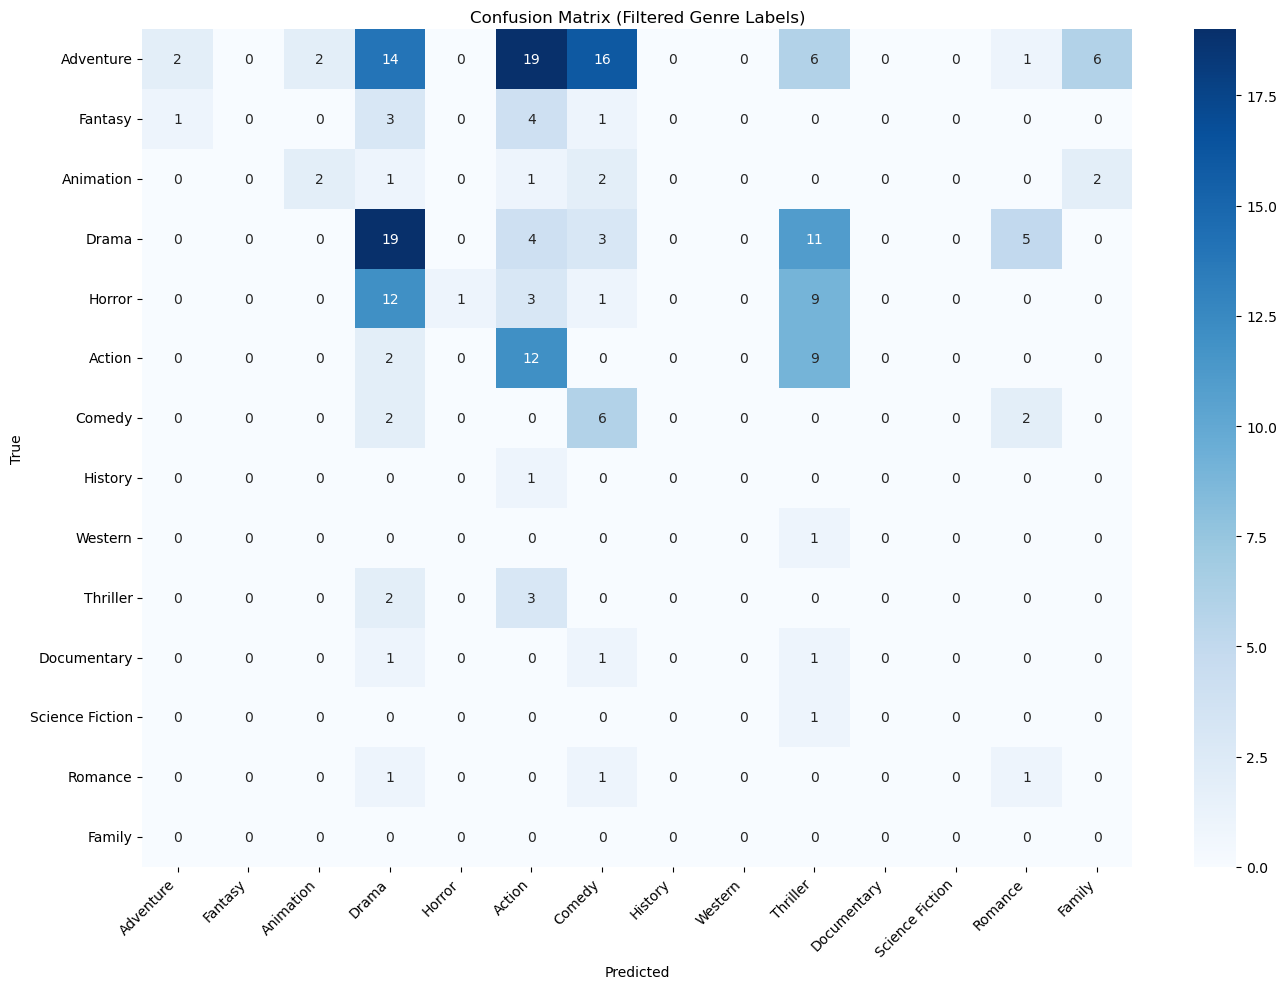

In [99]:
used_classes = np.unique(np.concatenate([true_labels, pred_labels]))

used_class_names = [genre_map.get(mlb.classes_[i], str(mlb.classes_[i])) for i in used_classes]

print("Classification Report:")
print(classification_report(true_labels, pred_labels, labels=used_classes, target_names=used_class_names))

cm = confusion_matrix(true_labels, pred_labels, labels=used_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Filtered Genre Labels)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

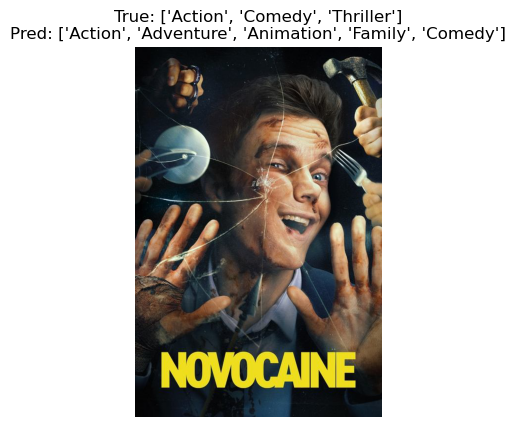

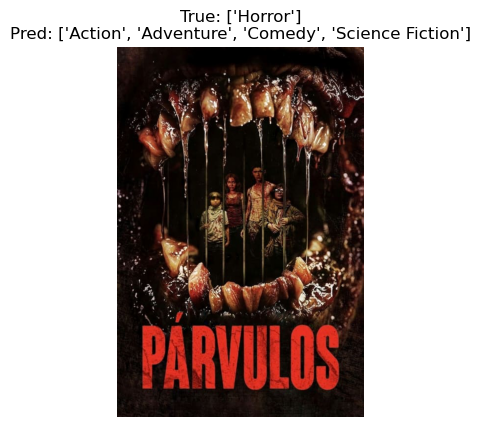

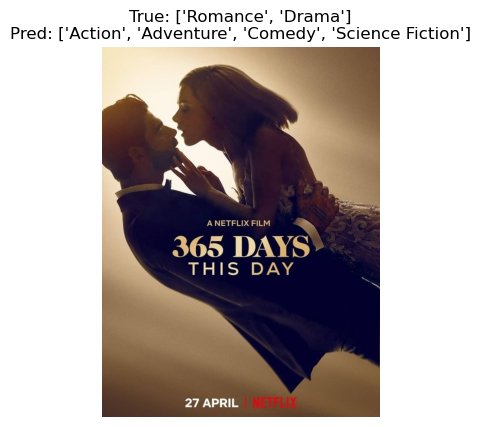

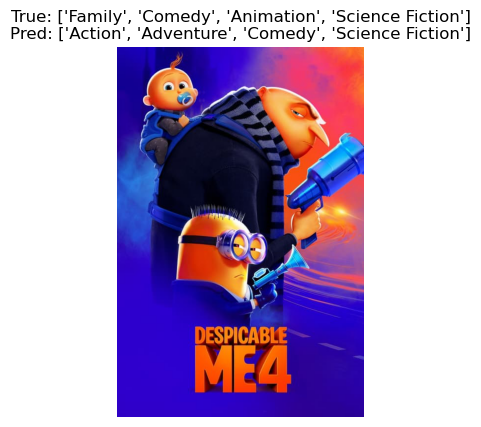

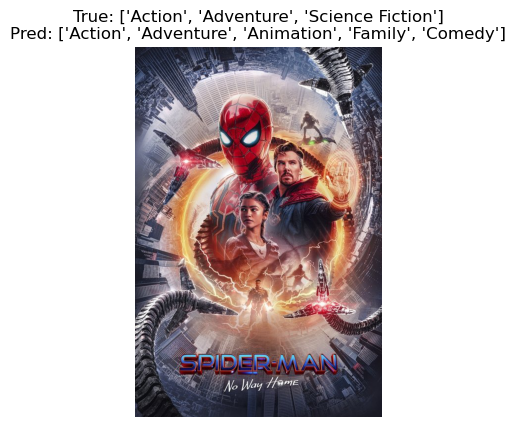

In [113]:
label_map = {i: genre for i, genre in enumerate(np.unique(df['genre']))}
predicted_genres = [label_map[i] for i in pred_labels]
sample_indices = np.random.choice(len(X_text_val), size=5, replace=False)

for i in sample_indices:
    img_path = df.iloc[i]['poster_file']
    img = Image.open(img_path)
    
    true_genre = df.iloc[i]['genre']
    pred_genre = label_map[pred_labels[i]]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_genre}\nPred: {pred_genre}")
    plt.show()

The classification report above provided precision, recall, and F1-score for each predicted genre. It highlights that genres like Drama and Action had the highest number of correct predictions — though this is likely influenced by their higher representation in the dataset.

In contrast, genres such as Crime, and Family were either poorly predicted or missed entirely, reflecting the model's struggle with underrepresented classes.

The weighted average F1-score remained low at approximately 0.18, indicating the model performs poorly across less frequent classes. This aligns with our earlier concern regarding class imbalance and limited generalizability — suggesting the model tends to favor dominant genres in the training data and fails to generalize effectively to rare classes.

Sample movie posters were also generated alongside their true and predicted genres just to give an insight on specific genre predictions. 

Some future improvements I would like to explore would be to address the genre representation imbalance, improve the text representations, utilize poster representation utilization, and include additional features such as audience reviews. 

Many of the genres were underrepresented in the dataset, leading to poor recall and F1-scores for those classes. Applying oversampling techniques (SMOTE for text) or loss reweighting could help improve performance across less frequent genres.

Instead of relying on the basic LSTM with word embeddings, utilizing developed models such as BERT could provide much better contextual understanding of the film plots hence potentially vastly imporoving our multimodal classifier.

Similar to utilizing BERT, there is a multitude of pretrained models such as CLIP that could further boost prediction accuracy based off of film posters.

Finally, including audience reviews might provide additional information that could guide the genre production such as including phrases like "scary" or "funny" that - paired with something like BERT - might make predictions have greater confidence.